In [2]:
import pandas as pd
import os
import json

df_10k = pd.read_csv('../data/askme-qa/askme-10k.csv')
df_full = pd.read_csv('../data/askme-qa/askme-full.csv')
df_full.head()

,_sa_instance_state_question,context,id_question,author_id,upvote,turns,text_question,paragraph_id,scope,timestamp,...,author_id_answer,question_id,timestamp_answer,_sa_instance_state_rating,answer_id,id_rating,timestamp_rating,author_id_rating,text_rating,value
0,<sqlalchemy.orm.state.InstanceState object at ...,In an article about 'Surface weather analysis'...,4,1,0,multi,How does the specific heat of water compare to...,176564,single-paragraph,2024-04-13 03:47:40,...,2,4,2024-04-13 03:47:47,<sqlalchemy.orm.state.InstanceState object at ...,2,1,2024-04-13 03:47:54,3,The answer is fully accurate and detailed. It ...,5
1,<sqlalchemy.orm.state.InstanceState object at ...,In an article about 'Surface weather analysis'...,5,1,0,multi,How does the specific heat of water compare to...,176564,single-paragraph,2024-04-13 03:47:40,...,2,5,2024-04-13 03:48:11,<sqlalchemy.orm.state.InstanceState object at ...,4,3,2024-04-13 03:48:19,3,The answer accurately summarizes the informati...,5
2,<sqlalchemy.orm.state.InstanceState object at ...,In an article about 'Surface weather analysis'...,6,1,0,multi,What happens to land temperature compared to w...,176564,single-paragraph,2024-04-13 03:47:40,...,2,6,2024-04-13 03:48:44,<sqlalchemy.orm.state.InstanceState object at ...,7,6,2024-04-13 03:48:50,3,The answer accurately summarizes the informati...,5
3,<sqlalchemy.orm.state.InstanceState object at ...,In an article about '2008 Maryland Terrapins f...,7,1,0,multi,Can you name the two offensive skill position ...,683013,single-paragraph,2024-04-13 03:51:53,...,2,7,2024-04-13 03:51:59,<sqlalchemy.orm.state.InstanceState object at ...,8,7,2024-04-13 03:52:06,3,The answer correctly identifies the two offens...,4
4,<sqlalchemy.orm.state.InstanceState object at ...,In an article about '2008 Maryland Terrapins f...,8,1,0,multi,Can you name the two offensive skill position ...,683013,single-paragraph,2024-04-13 03:51:53,...,2,8,2024-04-13 03:52:17,<sqlalchemy.orm.state.InstanceState object at ...,10,9,2024-04-13 03:52:24,3,The answer correctly identifies the two offens...,4


In [6]:
import nltk
from collections import Counter
from nltk.util import ngrams
from tqdm.notebook import tqdm

nltk.download('punkt')

def get_top_ngrams(questions, n, top_k=32):
    ngram_counter = Counter()
    for question in questions:
        tokens = nltk.word_tokenize(question.lower())
        ngram_counter.update(ngrams(tokens, n))
    return ngram_counter.most_common(top_k)

questions_10k = df_10k['text_question'].tolist()
questions_full = df_full['text_question'].tolist()

df_10k_ngram = pd.DataFrame(columns=[f'rank-{i+1}' for i in range(32)], index=[f'{i+1}-gram' for i in range(8)])
df_full_ngram = pd.DataFrame(columns=[f'rank-{i+1}' for i in range(32)], index=[f'{i+1}-gram' for i in range(8)])

for n in tqdm(range(1, 9), desc="Processing n-grams"):
    if os.path.exists('top_ngrams_10k.csv'):
        df_10k_ngram = pd.read_csv('top_ngrams_10k.csv', index_col=0)
    else: 
        top_ngrams_10k = get_top_ngrams(questions_10k, n)
        for rank, (ngram, freq) in enumerate(top_ngrams_10k):
            ngram_str = ' '.join(ngram)
            df_10k_ngram.at[f'{n}-gram', f'rank-{rank+1}'] = (ngram_str, freq)
        print(f"Top {n}-grams 10k: {top_ngrams_10k[:5]}")
        df_10k_ngram.to_csv('top_ngrams_10k.csv', index=True)

    if os.path.exists('top_ngrams_full.csv'):
        df_full_ngram = pd.read_csv('top_ngrams_full.csv', index_col=0)
    else:
        top_ngrams_full = get_top_ngrams(questions_full, n)
        for rank, (ngram, freq) in enumerate(top_ngrams_full):
            ngram_str = ' '.join(ngram)
            df_full_ngram.at[f'{n}-gram', f'rank-{rank+1}'] = (ngram_str, freq)
        print(f"Top {n}-grams full: {top_ngrams_full[:5]}")
        df_full_ngram.to_csv('top_ngrams_full.csv', index=True)

[nltk_data] Downloading package punkt to
[nltk_data]     /home/yuehengzhang/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


Processing n-grams:   0%|          | 0/8 [00:00<?, ?it/s]

Top 1-grams 10k: [(('the',), 13327), (('?',), 10011), (('of',), 7577), (('what',), 6056), (('in',), 5590)]
Top 1-grams full: [(('the',), 1554870), (('?',), 1143454), (('of',), 871267), (('what',), 688614), (('in',), 644879)]
Top 2-grams 10k: [(('of', 'the'), 2354), (('in', 'the'), 1454), (('what', 'is'), 1329), (('is', 'the'), 1232), (('was', 'the'), 967)]
Top 2-grams full: [(('of', 'the'), 261484), (('in', 'the'), 171527), (('what', 'is'), 151775), (('is', 'the'), 141391), (('was', 'the'), 108107)]
Top 3-grams 10k: [(('what', 'is', 'the'), 1033), (('what', 'was', 'the'), 682), (('what', 'type', 'of'), 580), ((',', 'and', 'what'), 378), (('in', 'what', 'year'), 345)]
Top 3-grams full: [(('what', 'is', 'the'), 118404), (('what', 'was', 'the'), 74469), (('what', 'type', 'of'), 65587), ((',', 'and', 'what'), 45513), (('in', 'what', 'year'), 38633)]
Top 4-grams 10k: [(('in', 'what', 'year', 'did'), 184), (('the', 'name', 'of', 'the'), 172), (('the', 'title', 'of', 'the'), 164), (('in', 'wh

/tmp/ipykernel_2847359/2830446822.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2847359/2830446822.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2847359/2830446822.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2847359/2830446822.py:32: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2847359/2830446822.py:32: UserWarning: set_ticklabels() should on

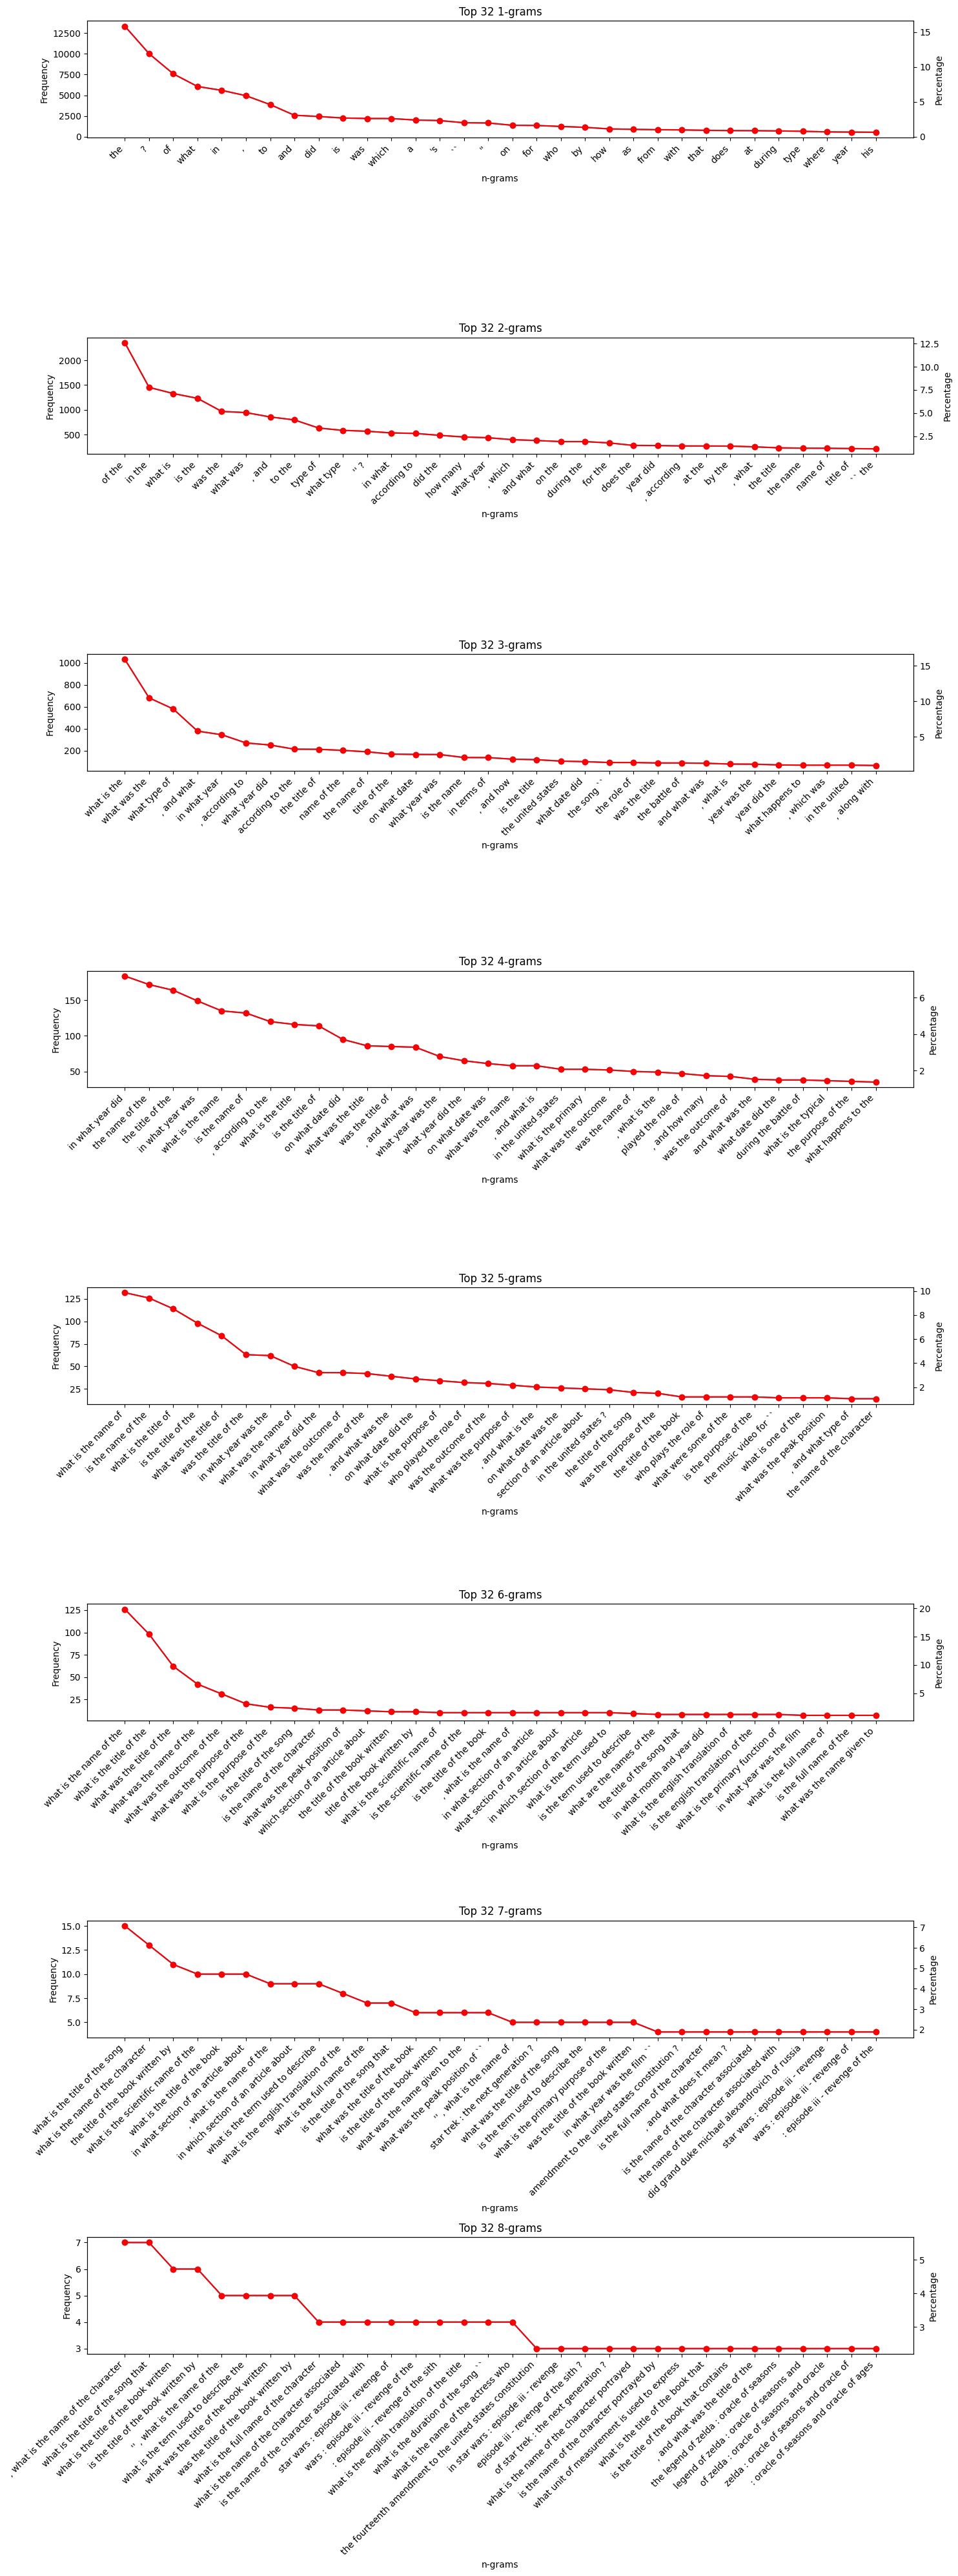

In [7]:
import pandas as pd
import matplotlib.pyplot as plt

df_10k_ngram = pd.read_csv('top_ngrams_10k.csv', index_col=0)

def parse_ngram_freq(cell):
    if isinstance(cell, str):
        ngram, freq = eval(cell)
        return ngram, freq
    return None, 0

fig, axs = plt.subplots(8, 1, figsize=(15, 40))
for i in range(8):
    n = i + 1
    ngram_labels = []
    frequencies = []
    
    for col in df_10k_ngram.columns:
        ngram, freq = parse_ngram_freq(df_10k_ngram.at[f'{n}-gram', col])
        if ngram:
            ngram_labels.append(ngram)
            frequencies.append(freq)

    total_freq = sum(frequencies)
    ratios = [freq / total_freq * 100 for freq in frequencies]
    
    ax1 = axs[i]
    ax1.plot(ngram_labels, frequencies, marker='o', label='Frequency')
    ax1.set_title(f'Top 32 {n}-grams')
    ax1.set_xlabel('n-grams')
    ax1.set_ylabel('Frequency')
    ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
    
    ax2 = ax1.twinx()
    ax2.plot(ngram_labels, ratios, marker='o', color='r', label='Percentage')
    ax2.set_ylabel('Percentage')
plt.tight_layout()
plt.show()

/tmp/ipykernel_2847359/2255723754.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2847359/2255723754.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2847359/2255723754.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2847359/2255723754.py:23: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
/tmp/ipykernel_2847359/2255723754.py:23: UserWarning: set_ticklabels() should on

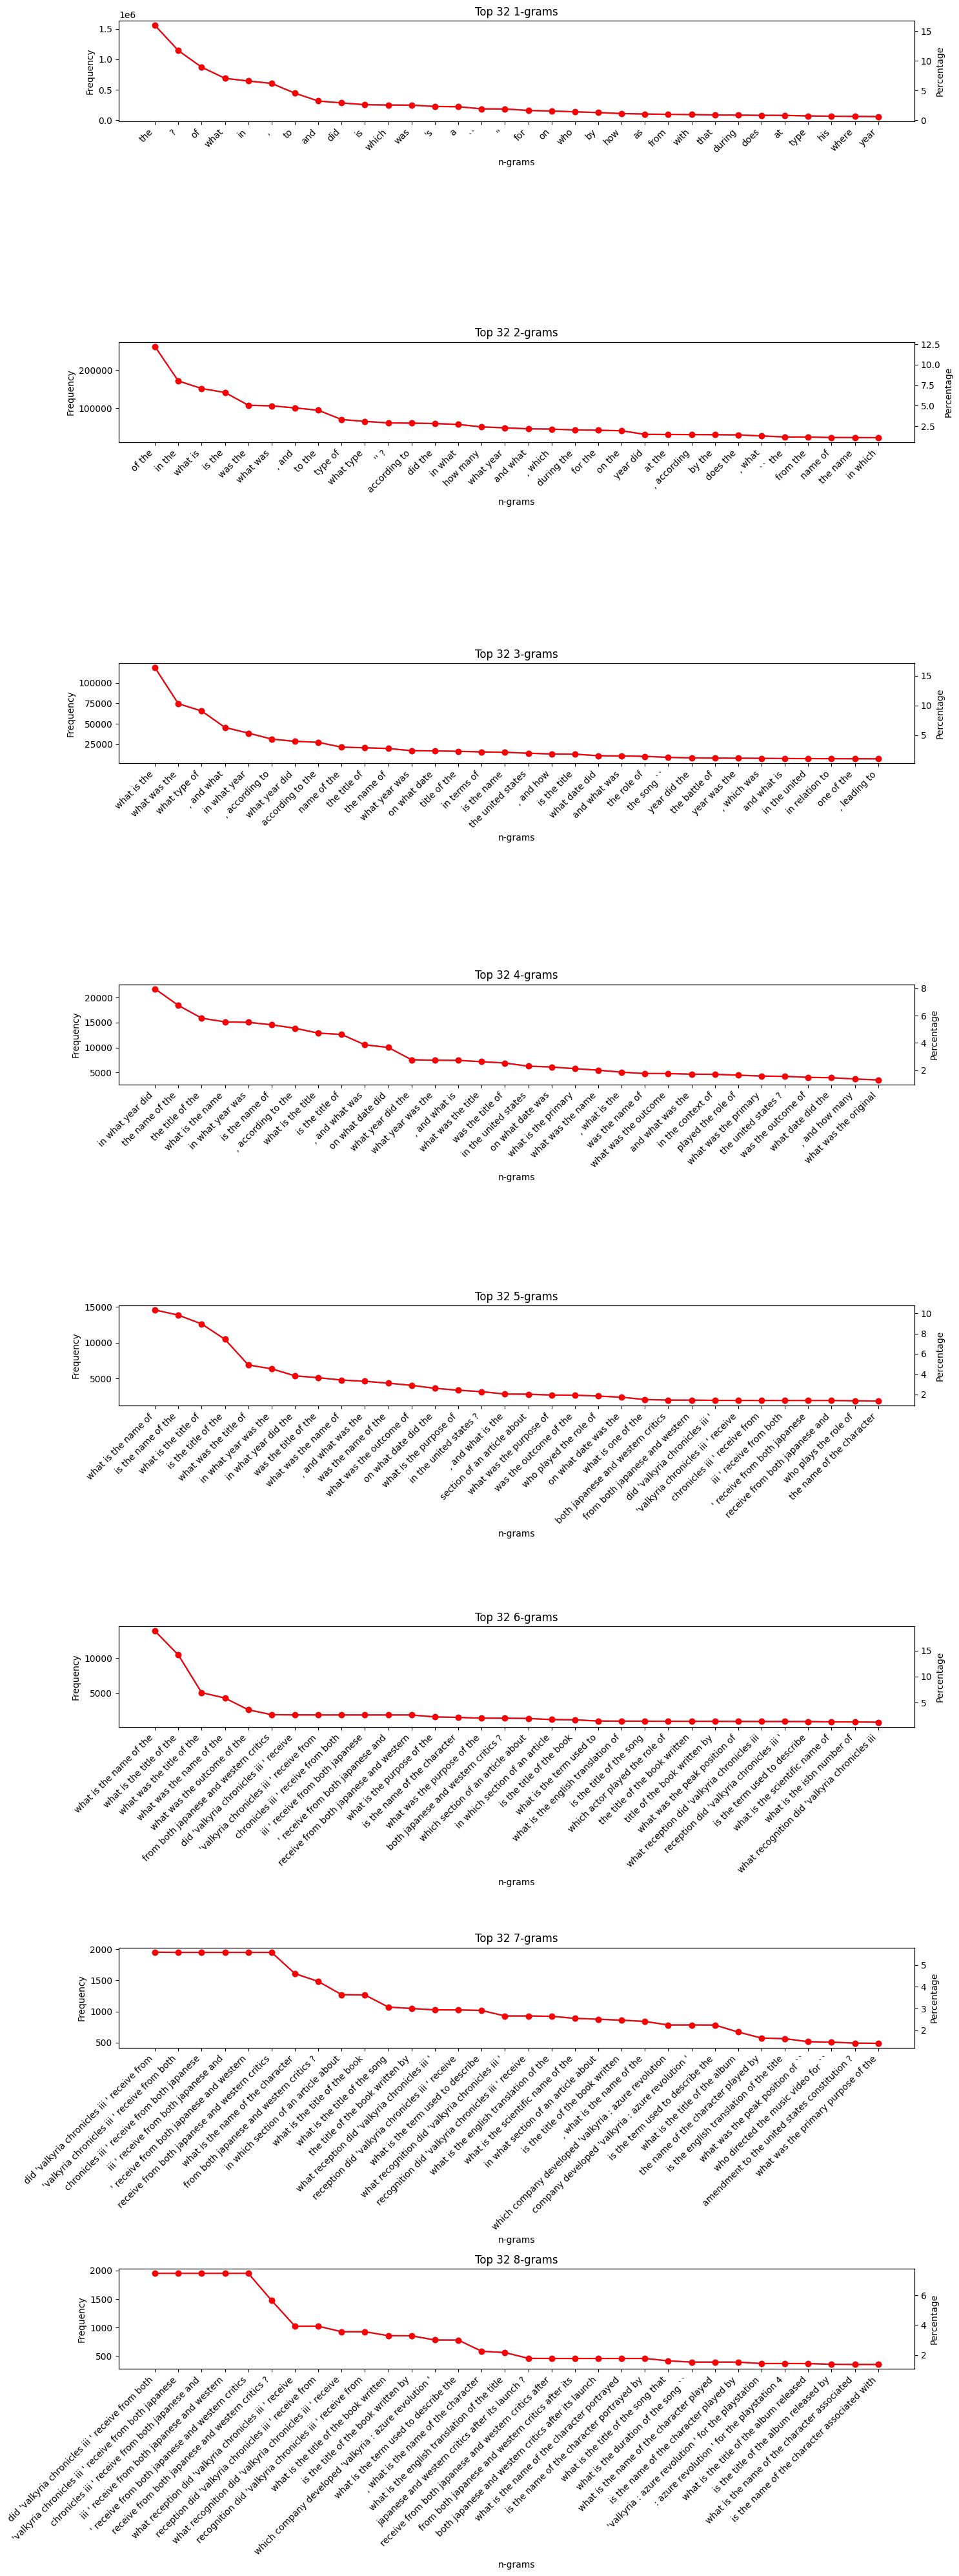

In [8]:
df_full_ngram = pd.read_csv('top_ngrams_full.csv', index_col=0)

fig, axs = plt.subplots(8, 1, figsize=(15, 40))
for i in range(8):
    n = i + 1
    ngram_labels = []
    frequencies = []
    
    for col in df_full_ngram.columns:
        ngram, freq = parse_ngram_freq(df_full_ngram.at[f'{n}-gram', col])
        if ngram:
            ngram_labels.append(ngram)
            frequencies.append(freq)

    total_freq = sum(frequencies)
    ratios = [freq / total_freq * 100 for freq in frequencies]
    
    ax1 = axs[i]
    ax1.plot(ngram_labels, frequencies, marker='o', label='Frequency')
    ax1.set_title(f'Top 32 {n}-grams')
    ax1.set_xlabel('n-grams')
    ax1.set_ylabel('Frequency')
    ax1.set_xticklabels(ngram_labels, rotation=45, ha='right')
    
    ax2 = ax1.twinx()
    ax2.plot(ngram_labels, ratios, marker='o', color='r', label='Percentage')
    ax2.set_ylabel('Percentage')
plt.tight_layout()
plt.show()